In [1]:
import os
import nibabel as nib
import sys
import pandas as pd 
import numpy as np
import subprocess
from glob import glob

In [2]:
cd

/home/athurai3


In [3]:
sub_P001 = 'projects/ctb-akhanf/athurai3/unet_contact_seg/sample_data/sub-P001/sub-P001_desc-corrected_actual.fcsv'
sub_P002 =  'projects/ctb-akhanf/athurai3/unet_contact_seg/sample_data/sub-P002/sub-P002_desc-corrected_actual.fcsv'
df = pd.read_csv(sub_P001, skiprows = 2)
new_df = df[['x','y','z']]
new_df['value'] = 1

df2 = pd.read_csv(sub_P002, skiprows = 2)
new_df2 = df2[['x','y','z']]
new_df2['value'] = 1
#np.savetxt(f'sample_data/sub-P001/sub-P001_desc-rigid_space-T1w_ct_landmarks.txt', new_df)

/tmp/ipykernel_31249/915865830.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['value'] = 1
/tmp/ipykernel_31249/915865830.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df2['value'] = 1


In [4]:
new_df

,x,y,z,value
0,31.781,75.375,8.609,1
1,16.076,92.885,72.155,1
2,17.438,79.000,-12.555,1
3,49.710,73.902,-1.223,1
4,7.629,60.094,0.981,1
5,57.863,60.597,5.935,1
6,14.039,54.438,0.292,1
7,63.661,32.950,9.785,1
8,15.375,39.406,3.801,1
9,63.035,32.923,29.240,1


In [5]:
new_df2

,x,y,z,value
0,-8.422,1.046,80.688,1
1,-52.318,11.344,76.534,1
2,-11.250,0.787,53.750,1
3,-25.549,-17.235,88.971,1
4,-7.668,-11.562,66.688,1
5,-59.269,-16.553,59.089,1
6,-8.914,24.562,71.750,1
7,-57.102,37.578,60.507,1
8,-11.898,17.703,61.062,1
9,-26.673,18.999,95.878,1


In [6]:
# https://www.geeksforgeeks.org/bresenhams-algorithm-for-3-d-line-drawing/
def create_line_mask(point1, point2, shape):
    # Create an empty mask with the specified shape
    mask = np.zeros(shape, dtype=bool)
    x1, y1, z1 = point1
    x2, y2, z2 = point2
    # Set the first element to true
    mask[x1, y1, z1] = True
    # Get the directions of each axis
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    dz = abs(z2 - z1)
    if x2 > x1:
        xs = 1
    else:
        xs = -1
    if y2 > y1:
        ys = 1
    else:
        ys = -1
    if z2 > z1:
        zs = 1
    else:
        zs = -1

    # Driving axis is X-axis
    if dx >= dy and dx >= dz:
        p1 = 2 * dy - dx
        p2 = 2 * dz - dx
        while x1 != x2:
            x1 += xs
            if p1 >= 0:
                y1 += ys
                p1 -= 2 * dx
            if p2 >= 0:
                z1 += zs
                p2 -= 2 * dx
            p1 += 2 * dy
            p2 += 2 * dz
            mask[x1, y1, z1] = True
        mask[x1, y1, z1] = True

    # Driving axis is Y-axis"
    elif dy >= dx and dy >= dz:
        p1 = 2 * dx - dy
        p2 = 2 * dz - dy
        while y1 != y2:
            y1 += ys
            if p1 >= 0:
                x1 += xs
                p1 -= 2 * dy
            if p2 >= 0:
                z1 += zs
                p2 -= 2 * dy
            p1 += 2 * dx
            p2 += 2 * dz
            mask[x1, y1, z1] = True
        mask[x1, y1, z1] = True

    # Driving axis is Z-axis"
    else:
        p1 = 2 * dy - dz
        p2 = 2 * dx - dz
        while z1 != z2:
            z1 += zs
            if p1 >= 0:
                y1 += ys
                p1 -= 2 * dz
            if p2 >= 0:
                x1 += xs
                p2 -= 2 * dz
            p1 += 2 * dy
            p2 += 2 * dx
            mask[x1, y1, z1] = True
        mask[x1, y1, z1] = True
    return mask

In [7]:
from skimage.morphology import dilation
from skimage.morphology import ball
from scipy.ndimage import gaussian_filter
#import mne

In [8]:
test_img = nib.load('projects/ctb-akhanf/athurai3/unet_contact_seg/sample_data/sub-P001/sub-P001_desc-rigid_space-T1w_ct.nii.gz')
test_aff = test_img.affine
test_shape = test_img.shape
test_data = np.asarray(test_img.dataobj)
inv_affine = np.linalg.inv(test_aff)

test_img2 = nib.load('projects/ctb-akhanf/athurai3/unet_contact_seg/sample_data/sub-P002/sub-P002_desc-rigid_space-T1w_ct.nii.gz')
test_aff2 = test_img2.affine
test_shape2 = test_img2.shape
test_data2 = np.asarray(test_img2.dataobj)
inv_affine2 = np.linalg.inv(test_aff2)

M = inv_affine[:3,:3]
abc = inv_affine[:3,3]

M2 = inv_affine2[:3,:3]
abc2 = inv_affine2[:3,3]

ras_coords = new_df[['x','y','z']].to_numpy()
vox_coords = np.zeros(ras_coords.shape)

# vox = np.round(mne.transforms.apply_trans(inv_affine, ras_coords)).astype(int)

for i in range(len(vox_coords)):
    vec = ras_coords[i,:]
    tvec = M.dot(vec) + abc
    vox_coords[i,:] = tvec[:3]

vox_coords = np.round(vox_coords).astype(int)
# print(vox)
# print(vox_coords)

In [9]:
import matplotlib.pyplot as plt

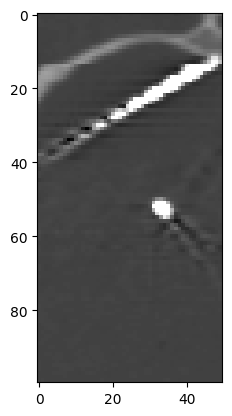

In [10]:
#plt.imshow((test_data[150:200,vox_coords[0,1],50:150]).transpose(), cmap='gray') 

In [11]:
final_mask = np.zeros(test_shape).astype(bool)
for i in range(0,len(vox_coords),2):
    pointa = vox_coords[i, :]
    pointb = vox_coords[i+1, :]
    test_mask = create_line_mask(pointa, pointb, test_data.shape)
   
    footprint = ball(4)
    dilated = dilation(test_mask, footprint)
    result = gaussian_filter(dilated.astype(float), sigma=0.6)
    final_mask += result>0

In [12]:
np.unique(final_mask)

array([False,  True])

In [13]:
clipped_img = nib.Nifti1Image(final_mask, test_aff, test_img.header)
nib.save(clipped_img, 'scratch/sub-P001_desc-rigid_space-T1w_electrodes_mask.nii.gz')

In [15]:
ras_coords2 = new_df2[['x','y','z']].to_numpy()
vox_coords2 = np.zeros(ras_coords2.shape)

for i in range(len(vox_coords2)):
    vec = ras_coords2[i,:]
    tvec = M2.dot(vec) + abc2
    vox_coords2[i,:] = tvec[:3]

vox_coords2 = np.round(vox_coords2).astype(int)

final_mask2 = np.zeros(test_shape2).astype(bool)
for i in range(0,len(vox_coords2),2):
    pointa = vox_coords2[i, :]
    pointb = vox_coords2[i+1, :]
    test_mask2 = create_line_mask(pointa, pointb, test_data2.shape)
   
    footprint = ball(4)
    dilated = dilation(test_mask2, footprint)
    result = gaussian_filter(dilated.astype(float), sigma=0.6)
    final_mask2 += result>0

In [16]:
clipped_img = nib.Nifti1Image(final_mask2, test_aff2, test_img2.header)
nib.save(clipped_img, 'scratch/sub-P002_desc-rigid_space-T1w_electrodes_mask.nii.gz')